In [1]:
# Other Libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
import pickle
import seaborn as sns

# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, LeakyReLU
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
TESS="TESS Toronto emotional speech set data/"

In [3]:
#TESS Dataset

path = []
emotion = []
dir_list = os.listdir(TESS)
dir_list.sort()
for i in dir_list:
    fname = os.listdir(TESS+i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

happy       400
surprise    400
angry       400
disgust     400
fear        400
sad         400
neutral     400
Name: labels, dtype: int64

In [4]:
ref = pd.concat([TESS_df], axis = 0)
print(ref.labels.value_counts())
ref.head()

happy       400
surprise    400
angry       400
disgust     400
fear        400
sad         400
neutral     400
Name: labels, dtype: int64


,labels,source,path
0,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...
1,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...
2,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...
3,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...
4,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...


In [5]:
df = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    print(len(mfccs))
    df.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

106
103
118
110
96
101
70
88
77
82
78
83
100
83
93
103
80
103
94
102
82
105
106
100
96
86
93
87
83
97
95
78
113
116
85
102
87
91
94
95
95
94
105
88
103
92
102
100
69
92
95
85
95
102
100
77
115
86
86
94
100
95
82
92
77
90
106
100
88
80
115
98
95
102
98
80
87
96
83
90
115
89
86
104
95
94
113
84
97
105
86
102
82
91
90
97
92
99
102
104
85
86
93
92
77
90
93
95
105
89
78
87
110
84
92
87
103
107
89
91
88
94
92
90
92
128
88
94
93
92
97
94
100
104
106
83
97
91
101
94
93
106
97
98
94
92
121
106
92
100
120
98
110
69
86
99
109
105
112
92
107
96
84
90
96
103
90
99
105
96
96
100
83
88
105
91
101
103
101
110
102
113
106
94
101
131
90
94
75
99
105
93
95
89
104
111
78
94
92
109
132
124
144
136
113
135
102
118
135
110
135
111
121
150
144
126
126
129
131
116
144
132
143
119
107
135
126
133
118
140
114
155
130
135
146
147
109
127
116
134
128
118
148
139
128
164
141
142
124
134
125
113
141
128
128
139
123
129
143
141
137
115
146
117
116
132
131
126
139
156
150
149
124
140
132
138
150
122
122
135
126
111
13

133
108
126
122
126
132
136
132
119
119
137
120
123
138
149
117
125
126
130
132
136
128
126
128
137
121
131
137
114
138
108
130
135
126
141
128
127
111
122
127
131
115
133
114
112
106
118
124
128
142
130
126
141
140
109
137
125
137
123
133
135
136
136
137
145
115
139
138
129
140
128
112
134
133
122
135
132
134
121
140
135
161
155
145
136
133
147
152
153
136
128
142
136
138
125
125
111
128
138
138
145
147
129
125
138
131
143
143
127
147
128
124
151
153
145
120
140
148
135
133
137
147
128
131
144
139
155
134
137
139
132
137
151
140
131
139
137
130
155
130
144
128
132
130
143
132
125
137
132
139
140
143
134
144
126
139
151
146
138
137
131
128
138
139
157
152
147
128
138
142
120
141
125
126
142
126
143
147
151
157
144
145
148
138
139
152
147
133
148
143
147
152
142
119
133
113
120
152
137
141
130
140
125
134
121
143
138
146
145
126
152
134
131
143
152
112
145
142
154
142
132
126
122
137
139
146
132
147
123
135
119
123
143
130
149
151
148
118
146
139
145
130
131
139
141
124
139
129
157
147


,feature
0,"[-14.638434, -17.479328, -26.613848, -25.56057..."
1,"[-13.811901, -17.268715, -27.322695, -27.47704..."
2,"[-14.89239, -18.566444, -28.097668, -28.5467, ..."
3,"[-10.043163, -13.771799, -28.228874, -27.99818..."
4,"[-19.030453, -22.088518, -31.511173, -30.10062..."


In [6]:
df.head()

,feature
0,"[-14.638434, -17.479328, -26.613848, -25.56057..."
1,"[-13.811901, -17.268715, -27.322695, -27.47704..."
2,"[-14.89239, -18.566444, -28.097668, -28.5467, ..."
3,"[-10.043163, -13.771799, -28.228874, -27.99818..."
4,"[-19.030453, -22.088518, -31.511173, -30.10062..."


In [7]:
mfcc_df = pd.DataFrame(df['feature'].values.tolist())
ref = ref.reset_index()
ref = ref.drop(columns = 'index') 
df = pd.concat([ref,mfcc_df],axis=1)

In [8]:
df

,labels,source,path,0,1,2,3,4,5,6,...,205,206,207,208,209,210,211,212,213,214
0,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-14.638434,-17.479328,-26.613848,-25.560577,-24.481157,-23.465237,-25.065012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-13.811901,-17.268715,-27.322695,-27.477049,-30.443869,-30.461901,-30.364758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-14.892390,-18.566444,-28.097668,-28.546700,-28.958017,-30.340248,-30.943810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-10.043163,-13.771799,-28.228874,-27.998186,-29.020769,-28.874743,-27.052284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-19.030453,-22.088518,-31.511173,-30.100624,-26.580198,-26.408049,-30.808247,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,sad,TESS,TESS Toronto emotional speech set data/YAF_sad...,-11.968084,-15.406763,-27.167522,-27.885582,-28.895691,-29.227583,-27.117409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2796,sad,TESS,TESS Toronto emotional speech set data/YAF_sad...,-10.008485,-14.674896,-25.038309,-24.692640,-26.183043,-25.815727,-25.819170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2797,sad,TESS,TESS Toronto emotional speech set data/YAF_sad...,-8.330002,-12.370701,-26.039032,-24.702271,-23.397322,-22.917076,-23.107155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2798,sad,TESS,TESS Toronto emotional speech set data/YAF_sad...,-16.001234,-19.055729,-28.437143,-27.302046,-28.091366,-27.433748,-27.071123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# replace NA with 0
df=df.fillna(0)

In [10]:
df

,labels,source,path,0,1,2,3,4,5,6,...,205,206,207,208,209,210,211,212,213,214
0,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-14.638434,-17.479328,-26.613848,-25.560577,-24.481157,-23.465237,-25.065012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-13.811901,-17.268715,-27.322695,-27.477049,-30.443869,-30.461901,-30.364758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-14.892390,-18.566444,-28.097668,-28.546700,-28.958017,-30.340248,-30.943810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-10.043163,-13.771799,-28.228874,-27.998186,-29.020769,-28.874743,-27.052284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,fear,TESS,TESS Toronto emotional speech set data/OAF_Fea...,-19.030453,-22.088518,-31.511173,-30.100624,-26.580198,-26.408049,-30.808247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,sad,TESS,TESS Toronto emotional speech set data/YAF_sad...,-11.968084,-15.406763,-27.167522,-27.885582,-28.895691,-29.227583,-27.117409,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2796,sad,TESS,TESS Toronto emotional speech set data/YAF_sad...,-10.008485,-14.674896,-25.038309,-24.692640,-26.183043,-25.815727,-25.819170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2797,sad,TESS,TESS Toronto emotional speech set data/YAF_sad...,-8.330002,-12.370701,-26.039032,-24.702271,-23.397322,-22.917076,-23.107155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2798,sad,TESS,TESS Toronto emotional speech set data/YAF_sad...,-16.001234,-19.055729,-28.437143,-27.302046,-28.091366,-27.433748,-27.071123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:


# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )



In [12]:
y_test.shape

(700,)

In [13]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [14]:
y_test

1088    happy
772     angry
2161    happy
1192    happy
1916     fear
        ...  
611     angry
530       sad
1494    angry
49       fear
1805     fear
Name: labels, Length: 700, dtype: object

In [15]:


# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape[1])
print(lb.classes_)

215
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [16]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [17]:
lb.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [18]:
import tensorflow

In [19]:
y_test.shape

(700, 7)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 149)               32184     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1050      
Total params: 33,234
Trainable params: 33,234
Non-trainable params: 0
_________________________________________________________________
Epoch 1/14
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 

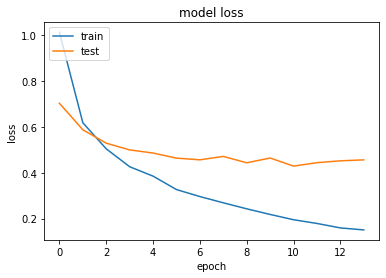

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
44/44 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

       angry       0.86      0.74      0.80        98
     disgust       0.92      0.89      0.91        94
        fear       0.77      0.86      0.81        94
       happy       0.91      0.91      0.91       106
     neutral       0.85      0.94      0.89       106
         s

In [20]:
# the model below gives 87% accuracy 

model = Sequential()
model.add(Dense(149, input_shape = (X_train.shape[1], ), activation ='relu', use_bias=True))
model.add(Dense(7, activation='softmax', use_bias=True))
opt = tensorflow.keras.optimizers.Adam(lr=0.0005)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=8, epochs=14, validation_data=(X_test, y_test))

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

preds = model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)

# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)

# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

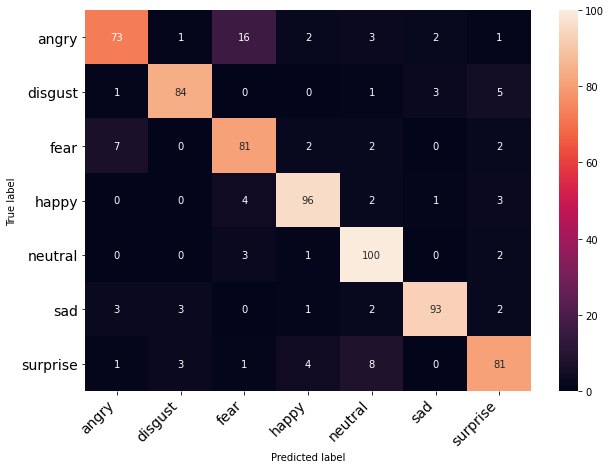

In [21]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print_confusion_matrix(c, class_names = classes)



In [22]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('modelVoice.tflite', 'wb') as f:
  f.write(tflite_model)


In [23]:
X, sample_rate = librosa.load("risposta.wav"
                              , res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100
                              ,offset=0.5
                             )
sample_rate = np.array(sample_rate)

In [24]:
# mean as the feature. Could do min and max etc as well. 
mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                    sr=sample_rate, 
                                    n_mfcc=13),
                axis=0)

In [25]:
len(mfccs)

80

In [26]:
mfccs

array([-36.26852 , -36.338947, -36.8809  , -34.944767, -33.461555,
       -32.26858 , -34.723907, -35.367702, -33.67998 , -30.948992,
       -31.71333 , -34.53534 , -35.431   , -36.64231 , -33.706436,
       -34.69364 , -33.094723, -33.390617, -32.713985, -32.52156 ,
       -34.08686 , -36.55515 , -36.657574, -33.72002 , -32.31144 ,
       -33.497334, -35.01321 , -37.820023, -38.06704 , -35.69512 ,
       -33.7309  , -34.035225, -35.45263 , -35.249386, -34.883236,
       -31.864666, -32.50589 , -33.64476 , -32.675453, -33.208363,
       -36.463684, -33.92453 , -31.480602, -32.665436, -34.37936 ,
       -33.505627, -33.91576 , -34.14208 , -34.329815, -35.187984,
       -32.6671  , -33.25067 , -32.95186 , -35.24347 , -37.864838,
       -34.74795 , -32.86433 , -33.592278, -34.89539 , -34.99396 ,
       -35.155483, -33.85624 , -34.067932, -35.268196, -33.909023,
       -31.296827, -31.325579, -29.249184, -31.878849, -31.707031,
       -26.606907, -25.021627, -28.170063, -30.772291, -29.951

In [27]:
df_mfcc = pd.DataFrame(columns=['feature'])

df_mfcc['feature'] = [mfccs]

In [28]:
df_mfcc

,feature
0,"[-36.26852, -36.338947, -36.8809, -34.944767, ..."


In [29]:
mfcc_df = pd.DataFrame(df_mfcc['feature'].values.tolist())

In [30]:
mfcc_df

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-36.26852,-36.338947,-36.880901,-34.944767,-33.461555,-32.268581,-34.723907,-35.367702,-33.679981,-30.948992,...,-26.606907,-25.021627,-28.170063,-30.772291,-29.951641,-30.278887,-29.098249,-29.715658,-30.002987,-30.719328


In [31]:
mfcc_df

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-36.26852,-36.338947,-36.880901,-34.944767,-33.461555,-32.268581,-34.723907,-35.367702,-33.679981,-30.948992,...,-26.606907,-25.021627,-28.170063,-30.772291,-29.951641,-30.278887,-29.098249,-29.715658,-30.002987,-30.719328


In [32]:
for i in range(80,215):
    mfcc_df[i]=0

In [33]:
mfcc_df

,0,1,2,3,4,5,6,7,8,9,...,205,206,207,208,209,210,211,212,213,214
0,-36.26852,-36.338947,-36.880901,-34.944767,-33.461555,-32.268581,-34.723907,-35.367702,-33.679981,-30.948992,...,0,0,0,0,0,0,0,0,0,0


In [34]:
mfcc_df[100]

0    0
Name: 100, dtype: int64

In [35]:
mfcc_df

,0,1,2,3,4,5,6,7,8,9,...,205,206,207,208,209,210,211,212,213,214
0,-36.26852,-36.338947,-36.880901,-34.944767,-33.461555,-32.268581,-34.723907,-35.367702,-33.679981,-30.948992,...,0,0,0,0,0,0,0,0,0,0


In [36]:
mfcc_df = np.array(mfcc_df, dtype="float32")

In [37]:
mfcc_df

array([[-36.26852 , -36.338947, -36.8809  , -34.944767, -33.461555,
        -32.26858 , -34.723907, -35.367702, -33.67998 , -30.948992,
        -31.71333 , -34.53534 , -35.431   , -36.64231 , -33.706436,
        -34.69364 , -33.094723, -33.390617, -32.713985, -32.52156 ,
        -34.08686 , -36.55515 , -36.657574, -33.72002 , -32.31144 ,
        -33.497334, -35.01321 , -37.820023, -38.06704 , -35.69512 ,
        -33.7309  , -34.035225, -35.45263 , -35.249386, -34.883236,
        -31.864666, -32.50589 , -33.64476 , -32.675453, -33.208363,
        -36.463684, -33.92453 , -31.480602, -32.665436, -34.37936 ,
        -33.505627, -33.91576 , -34.14208 , -34.329815, -35.187984,
        -32.6671  , -33.25067 , -32.95186 , -35.24347 , -37.864838,
        -34.74795 , -32.86433 , -33.592278, -34.89539 , -34.99396 ,
        -35.155483, -33.85624 , -34.067932, -35.268196, -33.909023,
        -31.296827, -31.325579, -29.249184, -31.878849, -31.707031,
        -26.606907, -25.021627, -28.170063, -30.

In [38]:
type(mfcc_df)

numpy.ndarray

In [39]:
mfcc_df.shape

(1, 215)

In [91]:
preds = model.predict(mfcc_df)
print("preds prima ",preds)
preds=preds.argmax(axis=1)
print("preds dopo ",preds)

preds prima  [[0.0000000e+00 0.0000000e+00 4.3708602e-16 0.0000000e+00 0.0000000e+00
  1.0000000e+00 0.0000000e+00]]
preds dopo  [5]


In [92]:
lb.classes_ #risulta che nella quinta posizione
            #c'è l'accuratezza maggiore, possiamo salvarci l'array sotto in flutter, in modo
            # tale che se preds risulta [5], allora attraverso l'array creato accediamo 
            # direttamente alla quinta posizione, seguendo l'ordine 
            #['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
            
emozione=lb.classes_[preds][0]
emozione

'sad'

In [93]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds))) #esiste una funzione apposita che passa dal valore 
#numerico all'emozione in stringa, ma usando flutter dobbiamo pensare ad usare altro, vedi sopra
# variabile emozione
preds = pd.DataFrame({'predictedvalues': preds})

In [94]:
preds

,predictedvalues
0,sad


In [95]:
import tensorflow as tf

In [96]:
intepreter = tf.lite.Interpreter(model_path="modelVoice.tflite")

In [97]:
intepreter.allocate_tensors()

In [98]:
input_details=intepreter.get_input_details()

In [99]:
input_details

[{'name': 'dense_input',
  'index': 0,
  'shape': array([  1, 215]),
  'shape_signature': array([  1, 215]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [100]:
output_details=intepreter.get_output_details()

In [101]:
output_details

[{'name': 'Identity',
  'index': 7,
  'shape': array([1, 7]),
  'shape_signature': array([1, 7]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [103]:
intepreter.set_tensor(input_details[0]['index'],mfcc_df) # qui passo direttamente mfcc_df
# che contiene i dati che mi interessano, in flutter dobbiamo vedere dato un audio, come calcolare
#l'mfcc

In [104]:
intepreter.invoke()

In [105]:
tflite_results=intepreter.get_tensor(output_details[0]['index'])

In [106]:
tflite_results

array([[0.000000e+00, 0.000000e+00, 4.370927e-16, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00]], dtype=float32)

In [116]:
preds_lite=tflite_results.argmax(axis=1)#prendo la massima accuratezza

In [118]:
print(preds_lite[0])  #raggiungo il massimo in quinta poszione, ma quale emozione è?

5


In [119]:
tflite_results[0][5] #accuratezza raggiunta in quinta posizione

1.0

In [120]:
emozioni=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
#array da creare in flutter, seguendo esattamente quest'ordine

In [123]:
emozione=emozioni[preds_lite[0]] #posizione 5 dell'array
emozione #sono triste

'sad'

In [133]:
# IN CONCLUSIONE
print("Dall' audio risulto ",emozione) #migliore
print("Con un'accuratezza del",tflite_results[0][5]*100,"%")

#ovviamnete possiamo stampare anche altre empzioni riportando tutti gli score, a caso
print("Dall' audio risulto ",emozioni[2])
print("Con un'accuratezza del",tflite_results[0][2]*100,"%") #essendo valori piccoli in 
# questo caso vedrei prendere solo le prime due cifre dopo la virgola


Dall' audio risulto  sad
Con un'accuratezza del 100.0 %
Dall' audio risulto  fear
Con un'accuratezza del 4.370926912359625e-14 %
